In [1]:
#First, some imports
import torch
import torch.nn as tn
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import h5py
%matplotlib inline

In [2]:
def get_data(N):
    assert N<=25000, "N must be less than 25000"
    with h5py.File("./data/ising_data.h5",'r') as F:
        data = F['data'][:N, ...,0]*1.0
        label = F['energy'][:N, ...]*1.0
    return data, label

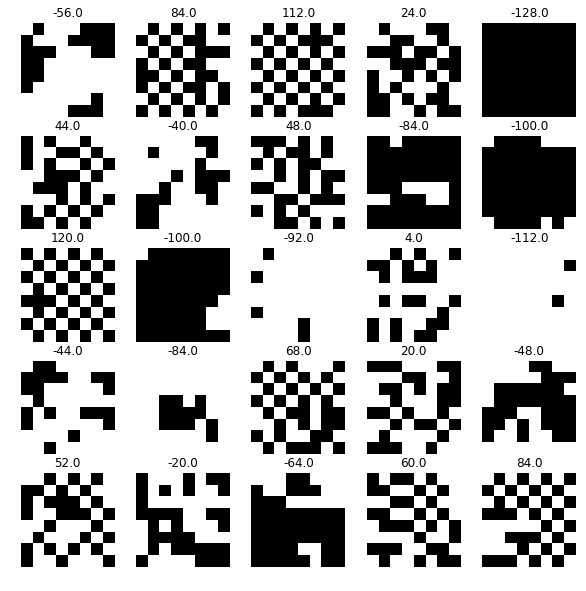

In [3]:
data, labels =  get_data(25)
fig, axs = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        axs[i][j].imshow(data[5*i+j,:,:], cmap='gray')
        axs[i][j].set_title('{0}'.format(labels[5*i+j][0]))
        axs[i][j].axis("off")

In [4]:
L = 8
f = 4
c = 1
tile_size = (f+2*c)**2

learning_rate = 0.01
batch_size = 500

In [5]:
model = torch.nn.Sequential(
            torch.nn.Linear(tile_size, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )

loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  




In [6]:
from torch.utils.data import Dataset, DataLoader

class EDNNDataset(Dataset):
    def __init__(self, data_in, labels_in, focus, context, wrapping=True):
        import numpy as np
        self.data = data_in
        self.labels = labels_in
        self.f = focus
        self.c = context
        self.wrapping = True
        self.L = [self.data.shape[1], self.data.shape[2]]
        
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __slice(self, in_, x1, y1, w, h): 
        """author: Kyle Mills"""
        return in_[x1:x1+w, y1:y1+h]

    def __getitem__(self, idx):
        raw = self.data[idx]
        label = self.labels[idx]
        
        tiles = []
        for iTile in range(self.L[0]//self.f):
            for jTile in range(self.L[1]//self.f):
                #calculate the indices of the centre of this tile:
                cot = (iTile*self.f + self.f//2, jTile*self.f + self.f//2)
                foc_centered = raw
                foc_centered = np.roll(foc_centered, self.L[0]//2 - cot[0], 0)
                foc_centered = np.roll(foc_centered, self.L[1]//2 - cot[1], 1)
                final = self.__slice(
                            in_=foc_centered,
                            x1=self.L[0]//2 - self.f//2-self.c,
                            y1=self.L[1]//2 - self.f//2-self.c,
                            w=self.f + 2*self.c,
                            h=self.f + 2*self.c
                            )
                tiles.append(final)
                
        return dict(tiles=tiles, label=label, original=raw)
    
    
data, labels = get_data(2500)
train_data = data[:2000]
test_data = data[2000:]
train_labels = labels[:2000]
test_labels = labels[2000:]


ising_dataset = EDNNDataset(data_in=train_data, labels_in=train_labels,
                            focus=f, context=c, wrapping=True)



ising_dataloader = DataLoader(ising_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=1)


In [7]:
num_epochs = 500
for epoch in range(num_epochs):
    for i, batched_data in enumerate(ising_dataloader):
        
        predicted = torch.zeros((batch_size, 1))
        
        for tile in batched_data['tiles']:
            tile = tile.reshape(batch_size, -1)
            predicted += model(tile.float())
            
        
        loss = loss_fn(predicted, batched_data["label"].float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print ('Epoch [{}/{}], Step [{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, i+1, loss.item()))


Epoch [1/500], Step [4], Loss: 4917.6509
Epoch [2/500], Step [4], Loss: 4684.3125
Epoch [3/500], Step [4], Loss: 4128.0332
Epoch [4/500], Step [4], Loss: 3158.3389
Epoch [5/500], Step [4], Loss: 2245.4192
Epoch [6/500], Step [4], Loss: 1361.5717
Epoch [7/500], Step [4], Loss: 795.3192
Epoch [8/500], Step [4], Loss: 449.5632
Epoch [9/500], Step [4], Loss: 375.3574
Epoch [10/500], Step [4], Loss: 427.6323
Epoch [11/500], Step [4], Loss: 472.1850
Epoch [12/500], Step [4], Loss: 403.9521
Epoch [13/500], Step [4], Loss: 319.6403
Epoch [14/500], Step [4], Loss: 325.7570
Epoch [15/500], Step [4], Loss: 297.9433
Epoch [16/500], Step [4], Loss: 330.2373
Epoch [17/500], Step [4], Loss: 311.7084
Epoch [18/500], Step [4], Loss: 280.1844
Epoch [19/500], Step [4], Loss: 277.2029
Epoch [20/500], Step [4], Loss: 254.7568
Epoch [21/500], Step [4], Loss: 292.6458
Epoch [22/500], Step [4], Loss: 259.8040
Epoch [23/500], Step [4], Loss: 240.8002
Epoch [24/500], Step [4], Loss: 239.9169
Epoch [25/500], Ste

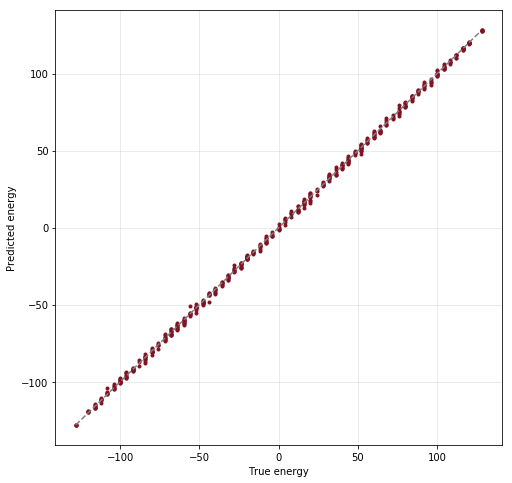

The median absolute error is 0.9044818878173828


In [8]:
ising_test_dataset = EDNNDataset(data_in=test_data, labels_in=test_labels,
                                 focus=f, context=c, wrapping=True)
ising_test_dataloader = DataLoader(ising_test_dataset, batch_size=len(ising_test_dataset),
                              shuffle=True, num_workers=1)

for i, all_data in enumerate(ising_test_dataloader):
    predicted = torch.zeros((ising_test_dataloader.batch_size, 1))
    for tile in batched_data['tiles']:
        tile = tile.reshape(batch_size, -1)
        predicted += model(tile.float())
        
prediction = predicted.detach().numpy()
test_labels = batched_data['label'].numpy()

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(test_labels.flatten(), prediction.flatten(), '.', color='#821122')
ax.plot(np.arange(-128,128), np.arange(-128,128), '--', color='gray')
ax.set_xlabel("True energy")
ax.set_ylabel("Predicted energy")
ax.grid(alpha=0.3)
plt.show()
print "The median absolute error is", np.median(np.abs(test_labels-prediction))
